In [36]:
import requests
import json
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This notebook hold the code which I used to scrape users and champion mastery data from the League of Legends API. The first section below will consist of the initial api requests that I performed to understand what the data from the API looks like so that I can manipulate it into the form I want. 

In [11]:
api_key = open('lol_api_key.txt', 'r').readline()

In [12]:
#Do a simple test query to ensure that the key is working
test = requests.get("https://na1.api.riotgames.com/lol/platform/v3/champions?api_key={}".format(api_key))
test.json()

{'champions': [{'active': True,
   'botEnabled': False,
   'botMmEnabled': False,
   'freeToPlay': False,
   'id': 266,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': False,
   'botMmEnabled': True,
   'freeToPlay': False,
   'id': 103,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': False,
   'botMmEnabled': True,
   'freeToPlay': False,
   'id': 84,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': True,
   'botMmEnabled': True,
   'freeToPlay': False,
   'id': 12,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': True,
   'botMmEnabled': True,
   'freeToPlay': True,
   'id': 32,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': False,
   'botMmEnabled': False,
   'freeToPlay': False,
   'id': 34,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': True,
   'botMmEnabled': True,
   'freeToPlay': False,
   'id': 1,
   'rankedPlayEnabled': True},
  {'active': True,
   'botEnabled': 

In [13]:
#Using my own account to examine the data
find_me = requests.get("https://na1.api.riotgames.com/lol/summoner/v3/summoners/by-name/jcbambi?api_key={}".format(api_key))
my_id = find_me.json()['id']
find_me.json()

{'accountId': 298937,
 'id': 272102,
 'name': 'Jcbambi',
 'profileIconId': 1301,
 'revisionDate': 1521789192000,
 'summonerLevel': 47}

In [14]:
my_mastery = requests.get("https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/{}?api_key={}".format(my_id,api_key))
my_mastery_data = pd.io.json.json_normalize(my_mastery.json())
my_mastery_data.head()

,championId,championLevel,championPoints,championPointsSinceLastLevel,championPointsUntilNextLevel,chestGranted,lastPlayTime,playerId,tokensEarned
0,59,4,17536,4936,4064,True,1519974571000,272102,0
1,21,4,17530,4930,4070,True,1521789192000,272102,0
2,89,4,16770,4170,4830,False,1513320507000,272102,0
3,111,4,15156,2556,6444,True,1517554529000,272102,0
4,12,4,14166,1566,7434,False,1491656492000,272102,0


In [84]:
my_mastery_data[my_mastery_data.championId == 24]

,championId,championLevel,championPoints,championPointsSinceLastLevel,championPointsUntilNextLevel,chestGranted,lastPlayTime,playerId,tokensEarned
7,24,3,11253,5253,1347,False,1521786950000,272102,0


In [17]:
#Created a DataFrame of the Champion data so that Names can be looked up and saved it to a csv file for later. 
champions = requests.get("https://na1.api.riotgames.com/lol/static-data/v3/champions/?api_key={}".format(api_key))
champlist=[]
for champ in champions.json()['data']:
    champlist.append(champions.json()['data'][champ])
    df_champions = pd.io.json.json_normalize(champlist)
df_champions.to_csv('df_champions.csv')
df_champions.head()

,id,key,name,title
0,24,Jax,Jax,Grandmaster at Arms
1,37,Sona,Sona,Maven of the Strings
2,18,Tristana,Tristana,the Yordle Gunner
3,110,Varus,Varus,the Arrow of Retribution
4,145,Kaisa,Kai'Sa,Daughter of the Void


    Now that we understand the data better we will start grabbing data from the API and saving the large requests loops to a file. This saves time and also has the benefit that we are always using the same list of users throughout the project.

In [19]:
def grabUsers(accountId, users):
    ''' grabUsers(str userId, list users)
    
    takes a user ID and a list of users
    returns a list of tuples of accountIds and summonerids'''
    time.sleep(1.25)
    games = requests.get("https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/{}/recent?api_key={}".format(accountId, api_key))
    matchIds = []
    for match in games.json()['matches']:
        matchIds.append(match['gameId'])
    for match in matchIds:
        time.sleep(1.25)
        game = requests.get("https://na1.api.riotgames.com/lol/match/v3/matches/{}?api_key={}".format(match, api_key))
        for user in game.json()['participantIdentities']:
            temp = (user['player']['accountId'], user['player']['summonerId'])
            if temp not in users:
                users.append(temp)
    return users

In [ ]:
#Gather a list of about 10,000 users using my account as the seed. 
#Try/except is used to avoid users which cannot be accessed
users = [(298937, 272102)]#start list of users with a seed (my account)
for acc, summ in users:    
    if len(users) < 10000:
        try:
            grabUsers(acc, users)
        except:
            continue
    else:
        break

In [ ]:
#save userlist
userfile = open('users.txt', 'w')
for user in users:
    userfile.write("{}, {}\n".format(user[0], user[1]))
userfile.close()

In [20]:
#Loaduserlist from txt and double check its formatting
users = np.genfromtxt('users.txt', delimiter=',').astype(int)
users

array([[   298937,    272102],
       [200912640,  38004669],
       [215203017,  52445679],
       ..., 
       [200310535,  37244595],
       [215140527,  52383413],
       [   622438,  89299097]])

In [21]:
def getMastery(user):
    '''getMastery(user)
    
    input is a int/str for a user's accountId. Returns a df of championId columns with a row of championPoints,
    and summonderId as the index'''
    mastery = requests.get("https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/{}?api_key={}".format(user, api_key))
    mastery_df = pd.io.json.json_normalize(mastery.json())
    out = pd.DataFrame(mastery_df[['championPoints', 'championId']]).sort_values('championId')
    out = out.set_index(out.championId).drop('championId', axis=1)
    out = out.T.rename(index={'championPoints': user})
    return out

In [22]:
#Test getMastery Function
getMastery(users[0][1])

championId,1,2,3,4,5,6,7,8,9,11,...,202,222,223,236,245,412,420,427,432,516
272102,6597,1142,1850,378,660,160,1191,7086,1322,882,...,2881,2955,3940,220,1593,125,5525,200,845,9910


In [ ]:
#Create a large dataframe of champion masteries with each row representing a user. Save to a csv.
#Using sleeps avoids API rate limiting and and the try/except is to avoid any errors that may pop up. 
m_df = pd.DataFrame(columns=sorted(champ_ids))
tracker = 0
for a,s in users:
    if(tracker%1000==0):
        print(tracker)
    tracker += 1
    time.sleep(1.25)
    try:
        m_df = pd.concat([m_df, getMastery(s)])
    except:
        continue
m_df.to_csv("mastery_df.csv")

In [23]:
#Reloading the mastery dataframe from file to double check
reclaim_mastery_df = pd.DataFrame.from_csv("mastery_df.csv")
mFill_df = reclaim_mastery_df.fillna(0)
mFill_df.head()

,1,2,3,4,5,6,7,8,9,10,...,268,412,420,421,427,429,432,497,498,516
272102,6597.0,1142.0,1850.0,378.0,660.0,160.0,1191.0,7086.0,1322.0,0.0,...,0.0,125.0,5525.0,0.0,200.0,0.0,845.0,0.0,0.0,9910.0
38004669,28662.0,0.0,883.0,5286.0,0.0,0.0,1038.0,1422.0,0.0,0.0,...,18437.0,10359.0,6000.0,1201.0,0.0,16242.0,16310.0,0.0,2768.0,0.0
52445679,6569.0,5570.0,10595.0,11929.0,1658.0,2517.0,29212.0,4339.0,1976.0,1326.0,...,7484.0,14579.0,11316.0,0.0,0.0,1944.0,3812.0,0.0,304.0,11180.0
24911748,0.0,5842.0,0.0,2502.0,177.0,0.0,93.0,3409.0,0.0,3625.0,...,0.0,11404.0,0.0,113.0,0.0,0.0,0.0,1189.0,0.0,0.0
21389010,111.0,236.0,0.0,1088.0,8931.0,0.0,0.0,0.0,0.0,836.0,...,573.0,690.0,0.0,0.0,0.0,0.0,596.0,0.0,0.0,205.0


At this point we have a List of users, DataFrame of Champion data and used those to build a DataFrame of mastery scores that we will use to develop the recommender. This dataframe (Above) has championids as columns, users as rows and each element represents the champion points for each combinations. Now that we have the data in the format we want, we will explore the data to look at some trends and statistics of the data

In [31]:
#Total Champion Points Sum
mFill_df.sum().sort_values(ascending=False).head()

412    289064356.0
157    265167147.0
67     263557123.0
81     228536943.0
202    227652027.0
dtype: float64

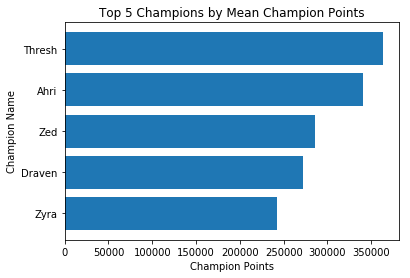

In [104]:
ticks = ['Zyra', 'Draven', 'Zed', 'Ahri','Thresh' ]
plt.barh([0,1,2,3,4], list(mFill_df.describe().mean().sort_values().tail()), tick_label = ticks)
plt.title('Top 5 Champions by Mean Champion Points')
plt.xlabel('Champion Points')
plt.ylabel('Champion Name')
plt.show()

In [33]:
mFill_df.describe().std().sort_values(ascending=True).head()

145    13676.141653
516    60886.206114
20     63793.335283
6      71383.336551
142    78066.915323
dtype: float64

In [35]:
mFill_df.describe().std().sort_values(ascending=False).head()

412    969689.232491
103    924256.674126
238    767840.379452
119    740386.891919
266    661385.180528
dtype: float64

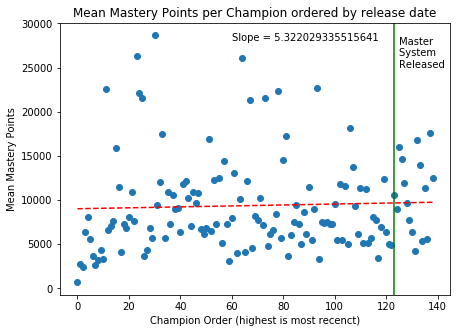

In [106]:
#Plotting mean mastery score by champion ordered by release date.
champs_release =open('champs_release.txt', 'r')
champs_ordered = []
for champ in champs_release.readlines():
    champs_ordered.append(champ.strip())
champs_release.close()

champs_plot = []
champs_id_label = []
sums = mFill_df.mean()
for champ in champs_ordered:
    champ_id = str(df_champions[df_champions.name == champ].get_values()[0][0])
    champs_id_label.append(champ_id)
    champs_plot.append(sums.loc[champ_id])

fig = plt.figure(figsize=(7,5))
x = list(reversed(range(len(champs_plot))))
plt.scatter(x, champs_plot)
z = np.polyfit(x, champs_plot,1)
trendline = np.poly1d(z)
plt.plot(x, trendline(x), 'r--')

plt.title("Mean Mastery Points per Champion ordered by release date")
plt.xlabel("Champion Order (highest is most recenct)")
plt.ylabel("Mean Mastery Points")
plt.text(60,28000, 'Slope = {}'.format(z[0]))
plt.text(125, 25000, 'Master \nSystem \nReleased')
plt.axvline(x=123, color='Green')
plt.show()